In [4]:
import os
import SAC
import quad_cnn_env_no_contact as qa
import torch 
import numpy as np
import pybullet as p
import pandas as pd
import seaborn as sns
import time as t
os.chdir('C:\\Users\\Duc Thien An Nguyen\\Desktop\\my_collections\\Python')

In [5]:
def evaluate(quantities):
    data = pd.DataFrame(columns=['trials','mean_velocity','mean_dis','sample_time'],index=[str(i)for i in quantities])
    for quant in quantities:
        eval = SAC.SAC_quad(
            load_model      = '2023-10-23-15-49-17_best_191.75',     
            envi            = qa,
            num_robot       = 9,
            learning_rate   = 0,
            data_size       = 500,
            batch_size      = 500*2,
            epochs          = 10000,
            thresh          = 2.,
            explore         = 1e-2,
            log_data        = False,
            save_model      = False,
            render_mode     = True, 
            norm            = False,
            print_rew       = True,
            real_time       = False,
            train_          = True,
            zeta            = 0.05,
            terrain_height  = [0., quant ],
            debug           = False,
            run             = 1    
        )
        sample_size = 1000
        eval.env.max_length = sample_size
        print(eval.env.max_length)
        base_position_list = []
        terminate_list = []
        observation = eval.env.get_obs()[0]
        for t in range(sample_size):
            temp_pos = []
            action, logprob, values     = eval.get_actor_critic_action_and_quality(torch.Tensor(observation).to(eval.device))
            action = np.array(action) + eval.run*eval.env.get_run_gait(eval.env.time_steps_in_current_episode)
            observation, reward, info   = eval.env.sim(np.array(action),real_time=eval.real_time,train=eval.train_)
            terminate_list += [info]
            for robotId in eval.env.robotId_list:
                base_position, base_orientation =  p.getBasePositionAndOrientation(robotId, physicsClientId = eval.env.physicsClient)[:2]
                temp_pos += [base_position[0]]
            base_position_list += [np.array(temp_pos)]
        new_base_list       = np.stack(base_position_list,axis=1).reshape((eval.num_robot*sample_size,*base_position_list[0].shape[1:])).reshape((-1,1))
        new_term_list       = np.stack(terminate_list,axis=1).reshape((eval.num_robot*sample_size,*terminate_list[0].shape[1:])).reshape((-1,1))
        record = []
        for i in range(len(new_term_list)):
            if new_term_list[i][0] == 1:
                record += [new_base_list[i-1][0]]
        velocity = np.mean(record)/(eval.env.max_length*eval.env.num_step*(1./240.))
        data.loc[str(quant),'trials'] = len(record)
        data.loc[str(quant),'mean_velocity'] = velocity
        data.loc[str(quant),'mean_dis'] = np.mean(record)
        data.loc[str(quant),'sample_time'] = eval.env.max_length*eval.env.num_step*(1./240.)
        eval.env.close()
    return data

In [6]:
q = [0., 0.0125, 0.025, 0.0375, 0.05]
df = evaluate(q)

Using seed: 1107
Using device:  cpu
----------------------------------------------------------------------------------------------------
ENVIRONMENT STARTED WITH SEED 0
Id: 0, Name: b'fl_shoulder_to_base', Range: (-0.785, 0.785)
Id: 1, Name: b'fl_thigh_to_shoulder', Range: (-0.785, 0.785)
Id: 2, Name: b'fl_bicep_to_thigh', Range: (-0.785, 0.785)
Id: 3, Name: b'fr_shoulder_to_base', Range: (-0.785, 0.785)
Id: 4, Name: b'fr_thigh_to_shoulder', Range: (-0.785, 0.785)
Id: 5, Name: b'fr_bicep_to_thigh', Range: (-0.785, 0.785)
Id: 6, Name: b'bl_shoulder_to_base', Range: (-0.785, 0.785)
Id: 7, Name: b'bl_thigh_to_shoulder', Range: (-0.785, 0.785)
Id: 8, Name: b'bl_bicep_to_thigh', Range: (-0.785, 0.785)
Id: 9, Name: b'br_shoulder_to_base', Range: (-0.785, 0.785)
Id: 10, Name: b'br_thigh_to_shoulder', Range: (-0.785, 0.785)
Id: 11, Name: b'br_bicep_to_thigh', Range: (-0.785, 0.785)
Robot mass: 2.0 and friction on feet: 0.5
Robot position loaded, force/torque sensors enable
Observation space:  

In [7]:
df

,trials,mean_velocity,mean_dis,sample_time
0.0,54,0.146991,6.124609,41.666667
0.0125,47,0.144859,6.035795,41.666667
0.025,47,0.110346,4.597767,41.666667
0.0375,44,0.088613,3.692215,41.666667
0.05,29,0.063599,2.649953,41.666667


<Axes: ylabel='mean_velocity'>

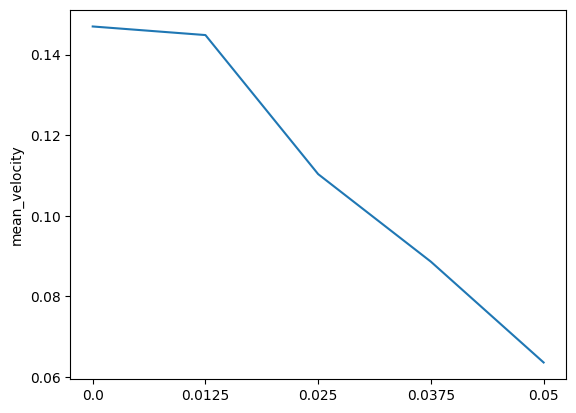

In [8]:
sns.lineplot(data=df.loc[:,'mean_velocity'])

In [9]:
eval.env.max_length

AttributeError: 'builtin_function_or_method' object has no attribute 'env'